In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
from tensorflow.keras.losses import MeanAbsoluteError

# from tensorflow import keras
# from tensorflow.keras import layers

2022-11-08 02:58:58.843249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 02:58:58.843283: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [105]:
# from Clustering import *
# from Forecasting import *
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

<module 'Forecasting' from '/home/anna/Desktop/MSU/научка/git/time_series/Forecasting.py'>

In [65]:
data = pd.read_csv("DataSet2.csv", sep=";")#, parse_dates=['Timestamp']) #, nrows=10)

In [4]:
columns = data.columns

In [5]:
data.head(5)

,Timestamp,ARO,SATUR_PRESSURE,BOIL_PERCENT,OCTANE_NUMBER,percent_01_LAB,percent_04_LAB,quality_01_LAB,pressure_01_LAB,consumption_09,...,temperature_08,temperature_14,temperature_01_LAB,temperature_21,temperature_22,temperature_23,temperature_24,consumption_01,pressure_11,temperature_20
0,01.01.2016 00:00:00,65.59,48.0,6.0,98.9,6.87640,64.05901,98.45841,56.06648,0.00292,...,134.7649,25.61035,90.86990,-3.72980,-7.13281,-1.0,11.86261,59.14596,70.77777,519.1353
1,01.01.2016 00:01:00,65.59,48.0,6.0,98.9,6.86923,64.01093,98.45134,56.04396,0.00292,...,134.8389,25.61035,90.90942,-3.72989,-7.13306,-1.0,11.86295,59.18106,70.93322,519.1353
2,01.01.2016 00:02:00,65.59,48.0,6.0,98.9,6.86095,63.99218,98.44153,56.01728,0.00292,...,134.6192,25.61055,90.88013,-3.73050,-7.13440,-1.0,11.86490,59.16980,70.03181,519.1346
3,01.01.2016 00:03:00,65.59,48.0,6.0,98.9,6.85725,63.98800,98.44115,56.01207,0.00292,...,134.6191,25.63477,90.87057,-3.73145,-7.13660,-1.0,11.86804,59.30387,70.46443,519.1337
4,01.01.2016 00:04:00,65.59,48.0,6.0,98.9,6.85561,63.98110,98.43896,56.00104,0.00292,...,134.6191,25.63477,90.90518,-3.73212,-7.13818,-1.0,11.87030,59.26101,69.81942,519.1330


In [80]:
def preprocess(df, K=5, dif=True):
    df = df.groupby(df.index // K).mean() #усреднение
    df_np = df.to_numpy()
    if dif:
        df_np = df_np[1:len(df_np), ...] - df_np[0:-1, ...] #дифференцирование
    df_np = (df_np - df_np.mean()) / df_np.std() #масштабирование
    df = pd.DataFrame(df_np, columns=df.columns)
    return df

In [81]:
#усреднение данных за 5 минут, дискретное дифференцирование, масштабирование
# preprocess(data).to_csv("DataSet_preprocessed.csv")

In [82]:
# preprocessed_data = pd.read_csv("DataSet_preprocessed.csv")

In [6]:
K = 5
df = data.groupby(data.index // K).mean() #усреднение
df_np = df.to_numpy()

In [7]:
df_np.shape

(408096, 67)

In [72]:
dataset = df_np[:100000, ...].astype(np.float64)

In [73]:
window_sizes_for_clustering = [1, 2, 3, 10]
Ns_clusters = [5, 7, 9]

In [74]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
mase = MeanAbsoluteScaledError()

N_clusters=5, 5, 101, (261, 67)
Before prediction: train_X.shape=(19663, 10, 67), train_y.shape=(19663, 67), test_X.shape=(4914, 10, 67), test_y.shape=(4914, 67)
Epoch 1/10
154/154 [==============================] - 2s 5ms/step - loss: 0.2787
Epoch 2/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2672
Epoch 3/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2606
Epoch 4/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2528
Epoch 5/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2468
Epoch 6/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2423
Epoch 7/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2384
Epoch 8/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2347
Epoch 9/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2317
Epoch 10/10
154/154 [==============================] - 0s 1ms/step
Cluster 0, error=0.7939082333684303
Before

KeyboardInterrupt: 

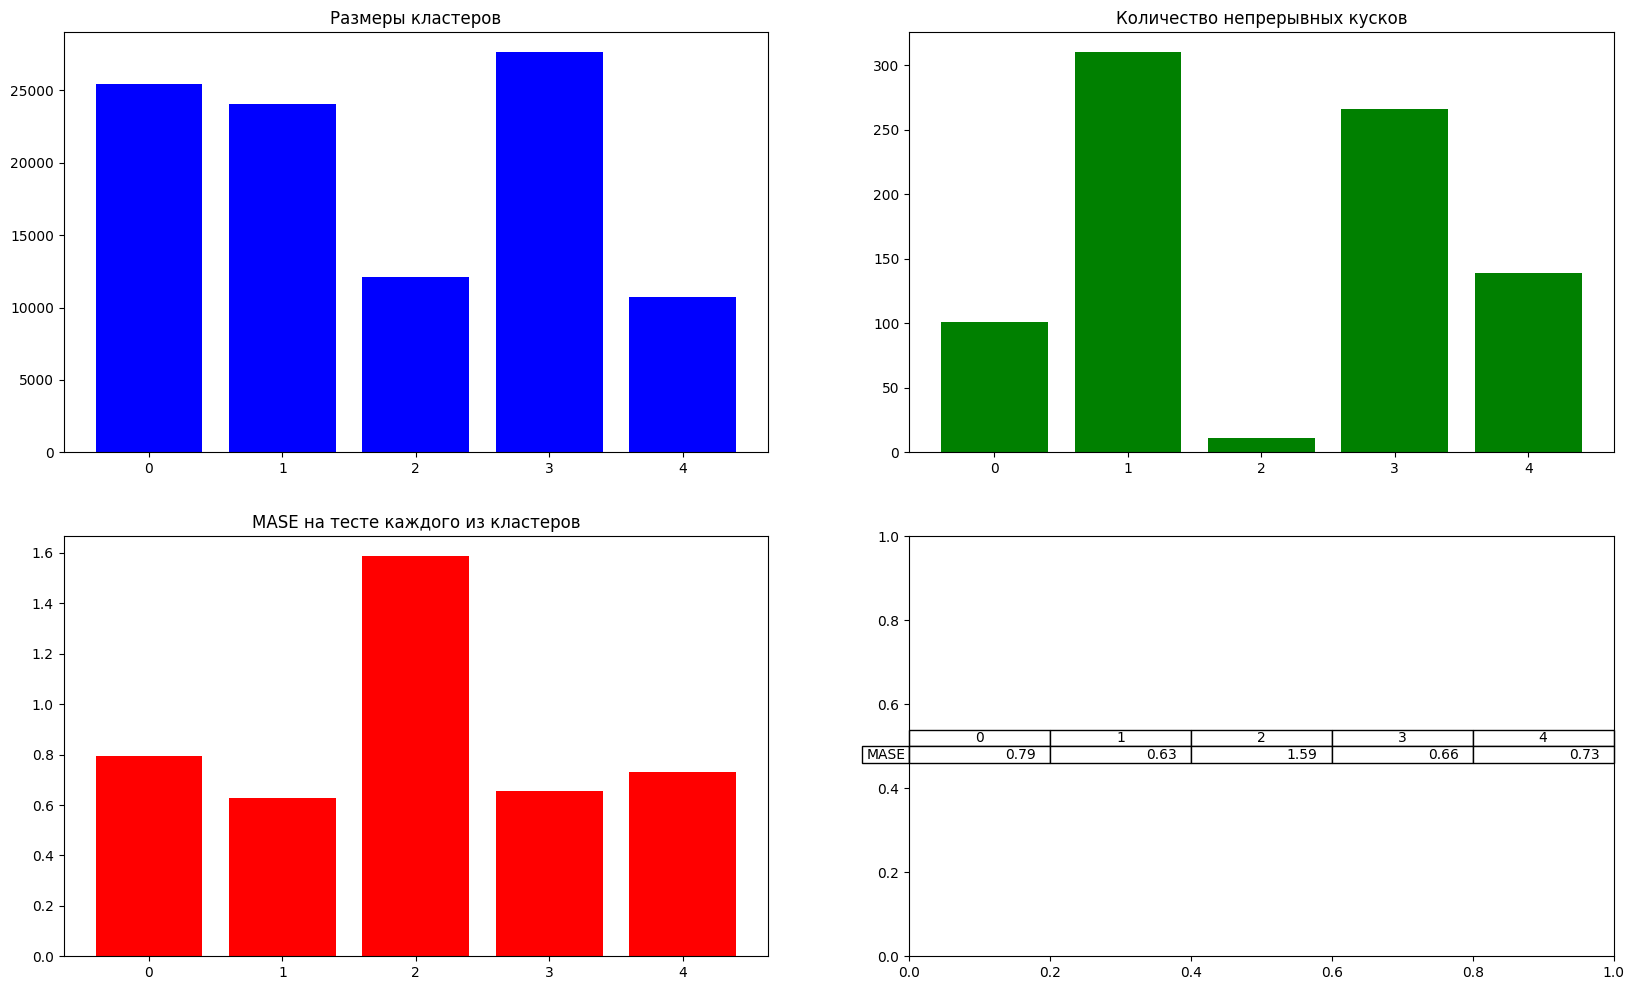

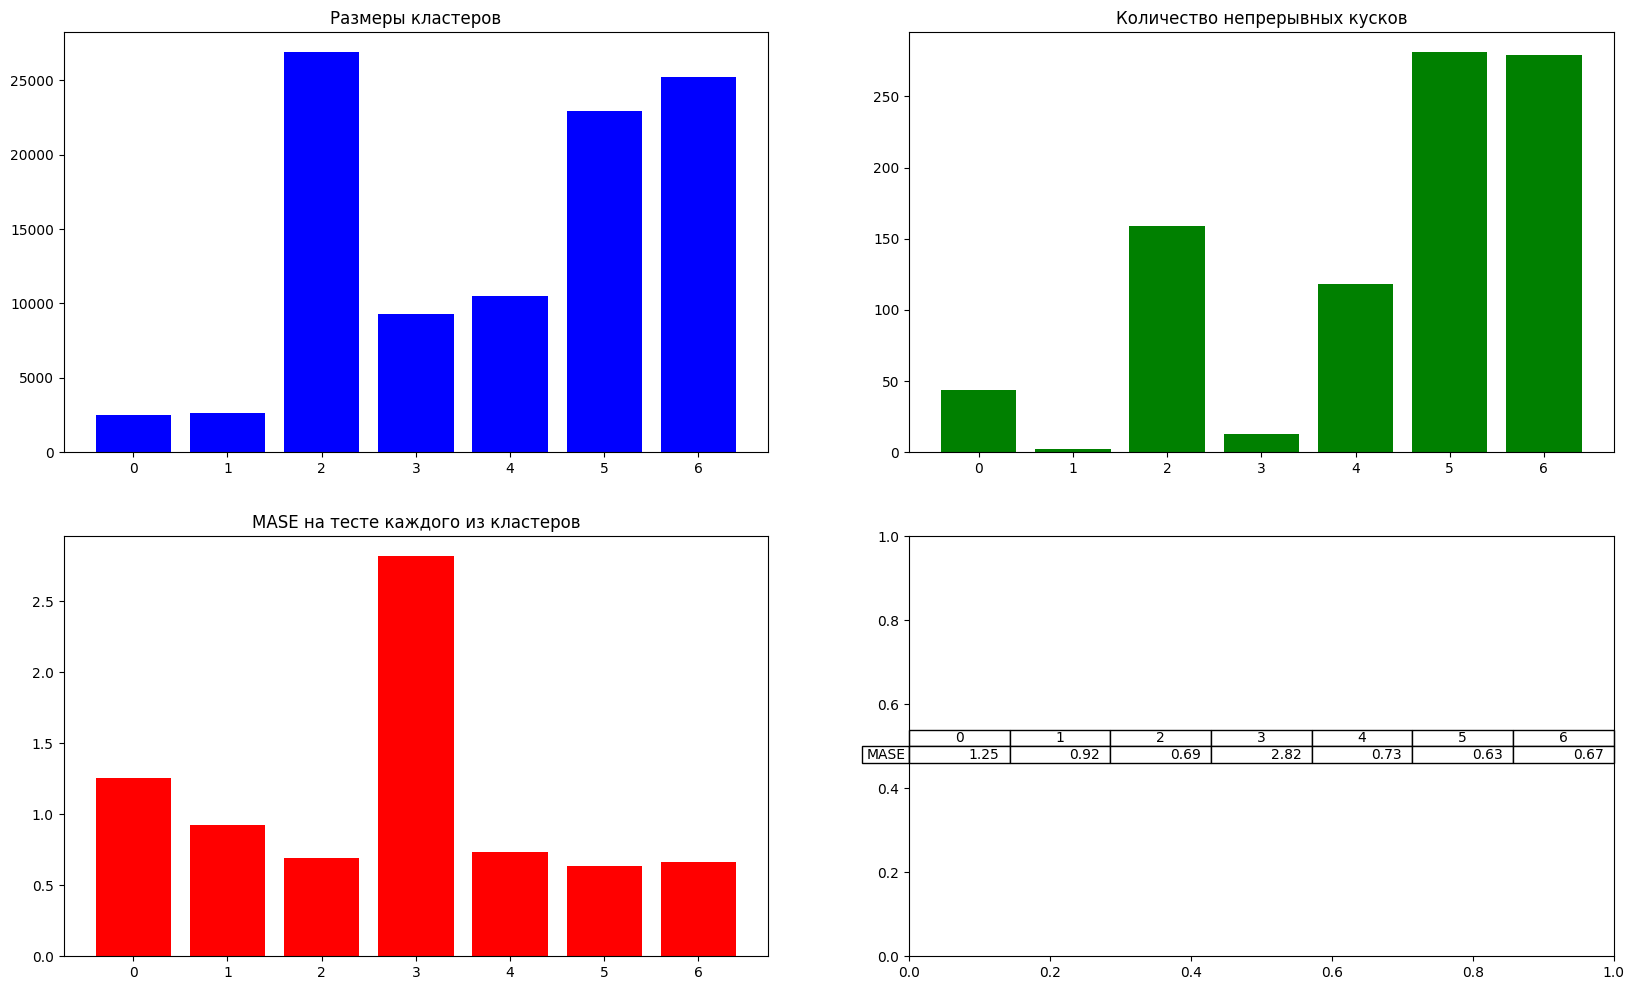

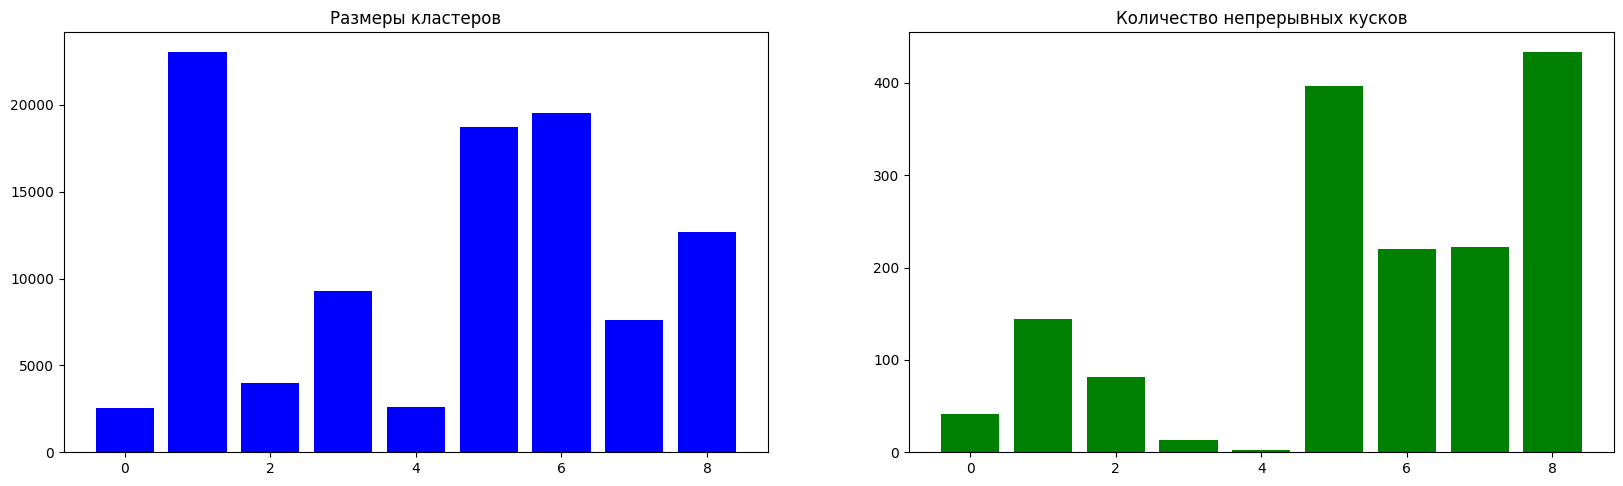

In [107]:
mae = MeanAbsoluteError()

for window_size in window_sizes_for_clustering:
    for N_clusters in Ns_clusters:
        dataset_windows, dataset_y = Forecasting.create_windows(dataset, window_size=window_size)
        clusters_labels = Clustering.KMeans_for_windows(dataset_windows, W=window_size, N_clusters=N_clusters, max_iter=50)
        datasets_clusters = Clustering.flatten_from_interceting_windows(dataset_windows, clusters_labels, W=window_size, \
                N_clusters=N_clusters) #можно и dataset_y включать. +1 
        print(f"{N_clusters=}, {len(datasets_clusters)}, {len(datasets_clusters[0])}, {datasets_clusters[0][0].shape}")
        plt.figure(figsize=(20, 12))
        plt.subplot(2, 2, 1)
        plt.bar(np.arange(N_clusters), [np.sum(clusters_labels == i) for i in range(N_clusters)], color='blue')
        plt.title("Размеры кластеров")
        plt.subplot(2, 2, 2)
        plt.bar(np.arange(N_clusters), [len(datasets_clusters[i]) for i in range(N_clusters)], color="green")
        plt.title("Количество непрерывных кусков")
        ###window_size for model
        errors = [1] * N_clusters
        for cluster_num in range(N_clusters):
            sc = Forecasting.MyStandardScaler()
            sc.fit(datasets_clusters[cluster_num])
            prepared_data = sc.transform(datasets_clusters[cluster_num])
            data_X, data_y = Forecasting.create_windows(prepared_data, window_size=10)
            # print(f"{len(data_X)=}, {data_X[0].shape=}, {len(data_y)=}, {data_y[0].shape=}")
            train_X, train_y, test_X, test_y = Forecasting.split_to_train_test(data_X, data_y)
            print(f"Before prediction: {train_X.shape=}, {train_y.shape=}, {test_X.shape=}, {test_y.shape=}")
            #не просто конец брать, а из каждого куска непрерывности. Будет ли сильно оптимистичнее оценка? 
            if len(test_X.shape) == 2 or test_X.shape[0] == 0:
                print(f"Fail! {test_X.shape=}")
                continue
            if len(train_X.shape) == 2 or train_X.shape[0] == 0:
                print(f"Fail! {train_X.shape=}")
                continue
            model, history = Forecasting.learn(train_X, train_y)
            predicted = model.predict(test_X)
            error = mase(test_y, predicted, y_train=train_y)
            errors[cluster_num] = error
            print(f"Cluster {cluster_num}, {error=}")
        plt.subplot(2, 2, 3)
        plt.bar(np.arange(N_clusters), errors, color="red")
        plt.title("MASE на тесте каждого из кластеров")
        plt.subplot(2, 2, 4)
        plt.table(cellText= [[f"{x:.2f}" for x in errors]],
                      rowLabels=["MASE"],
                      colLabels=list(range(N_clusters)),
                      loc='center')
        plt.savefig(f"plots/Dataset2/{N_clusters=}  W={window_size}.png")
        

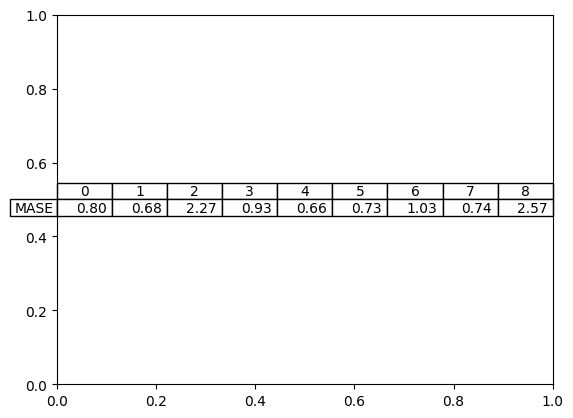

In [104]:
        # plt.bar(np.arange(N_clusters), errors, color="red")

the_table = plt.table(cellText= [[f"{x:.2f}" for x in errors]],
                      rowLabels=["MASE"],
                      colLabels=list(range(N_clusters)),
                      loc='center')

In [103]:
len([f"{x:.2f}" for x in errors])


9

Промежуточная отладка

In [190]:
# from Clustering import *
# from Forecasting import *
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

<module 'Forecasting' from '/home/anna/Desktop/MSU/научка/git/time_series/Forecasting.py'>

In [60]:
labels = np.array([1, 0, 0, 0, 2, 2, 1])
d = np.arange(7 * 5 * 2).reshape(7, 5, 2)
res = Clustering.flatten_from_interceting_windows(d, labels, N_clusters=3)
res[0]

tmp.shape=(1, 5, 2), cluster_num=1, len(dataset_result)=3
tmp.shape=(1, 7, 2), cluster_num=0, len(dataset_result)=3
tmp.shape=(1, 6, 2), cluster_num=2, len(dataset_result)=3
tmp.shape=(1, 5, 2), cluster_num=1, len(dataset_result)=3


[array([[10, 11],
        [12, 13],
        [14, 15],
        [16, 17],
        [18, 19],
        [28, 29],
        [38, 39]])]

In [194]:
a = [np.arange(i, i + 8).reshape(2, 4) for i in range(3)]
print(*a, sep="\n")
sc = Forecasting.MyStandardScaler()
sc.fit(a)
print(f"{sc.mean=}, {sc.std=}")
cur_cnt = 8

d = np.sqrt(np.sum(np.row_stack([np.sum(np.square(part - sc.mean), axis=0) / cur_cnt for part in a]), axis=0))
print(f"{d=}")

b = sc.transform(a)
len(b), b[0].shape, sc.mean, sc.std

[[0 1 2 3]
 [4 5 6 7]]
[[1 2 3 4]
 [5 6 7 8]]
[[ 4  5  6  7]
 [ 8  9 10 11]]
sc.mean=array([4., 4., 4., 4.]), sc.std=array([0., 0., 0., 0.])
d=array([2.29128785, 2.34520788, 2.6925824 , 3.24037035])


/home/anna/Desktop/MSU/научка/git/time_series/Forecasting.py:101: RuntimeWarning: invalid value encountered in divide
  result_data[i] = (result_data[i] - self.mean) / self.std


(3, (1, 4), array([4., 4., 4., 4.]), array([0., 0., 0., 0.]))

In [198]:
a = [np.array([[1, 2], [1, 3]]), np.array([[1, 2], [2, 1]]), np.array([[1, 2], [3, 2]])]
sc = Forecasting.MyStandardScaler()
sc.fit(a)
print(sc.transform(a), sc.mean, sc.std)

[array([[-1.22474487,  1.22474487]]), array([[ 0.        , -1.22474487]]), array([[1.22474487, 0.        ]])] [1. 0.] [0.81649658 0.81649658]


In [7]:
columns = preprocessed_data.columns

In [8]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.metrics import MeanAbsoluteError


In [9]:
# from tensorflow.keras.utils import plot_model


quality >= 90 :
L = 431204;  R = 2040480; len = 1609276

Частично данные из DataSet2

In [10]:
partial_data = preprocessed_data.iloc[431205 // 5:531205 // 5, 1:]
partial_data.shape

(20000, 67)

In [9]:
predicted_values = predicted[:100, ...]
print(f"{test_X.shape=}, {predicted_values.shape=}")

for i in range(predicted_values.shape[-1]):
    plt.plot(predicted_values[:, i], color="red", label="prediction")
    plt.plot(test_y[:100, i], color="green", label="origin")
    plt.xlabel("Time")
    plt.ylabel(str(columns[i + 1]))
    plt.legend()
    plt.savefig("plots/partionDataSet2/" + str(i) + " " + str(columns[i + 1]) + '.png')
    # plt.show()
    plt.clf()

NameError: name 'predicted' is not defined

In [ ]:
def compare(y_true, y_predict, show_window_size=200):
    

Кластеризация


In [49]:
import importlib
import Clustering
importlib.reload(Clustering)
import Forecasting
importlib.reload(Forecasting)

<module 'Forecasting' from '/home/anna/Desktop/MSU/научка/git/time_series/Forecasting.py'>

In [40]:
window_size = 5
dataset_windows, dataset_y = Forecasting.create_windows(partial_data, window_size=window_size)
print(dataset_windows.shape, dataset_y.shape)

(20000, 67)
(19995, 5, 67) (19995, 67)


In [41]:
N_clusters = 5
clusters_labels = Clustering.KMeans_for_windows(dataset_windows, N_clusters=N_clusters)

In [47]:
for i in range(N_clusters):
    print(i, np.sum(clusters_labels == i))

0 19685
1 50
2 94
3 35
4 24


In [42]:
clusters_labels.shape, partial_data.shape

((19995,), (20000, 67))

In [48]:
clusters_train_X, clusters_train_y, clusters_test_X, clusters_test_y = Forecasting.create_train_test_in_clusters(dataset_windows, dataset_y, clusters_labels, N_clusters)
mae = MeanAbsoluteError()
for i in range(N_clusters):
    model, history = Forecasting.learn(clusters_train_X[i], clusters_train_y[i])
    predicted = model.predict(clusters_test_X[i])
    print(predicted.shape)
    error = mae(clusters_test_y[i], predicted).numpy()
    print(f"Cluster {i}, {error=}")


n_split=15748
train_X.shape=(15748, 5, 67), train_y.shape=(15748, 67), test_X.shape=(3937, 5, 67), test_y.shape=(3937, 67)
n_split=40
train_X.shape=(40, 5, 67), train_y.shape=(40, 67), test_X.shape=(10, 5, 67), test_y.shape=(10, 67)
n_split=75
train_X.shape=(75, 5, 67), train_y.shape=(75, 67), test_X.shape=(19, 5, 67), test_y.shape=(19, 67)
n_split=28
train_X.shape=(28, 5, 67), train_y.shape=(28, 67), test_X.shape=(7, 5, 67), test_y.shape=(7, 67)
n_split=19
train_X.shape=(19, 5, 67), train_y.shape=(19, 67), test_X.shape=(5, 5, 67), test_y.shape=(5, 67)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50)                23600     
                                                                 
 dense_9 (Dense)             (None, 67)                3417      
                                                                 
Total params: 27,017
Tr

2022-11-03 18:18:07.172613: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 21102320 exceeds 10% of free system memory.


247/247 - 2s - loss: 2.1710 - mean_absolute_error: 0.2011 - 2s/epoch - 6ms/step
Epoch 2/10
247/247 - 1s - loss: 2.1672 - mean_absolute_error: 0.1989 - 610ms/epoch - 2ms/step
Epoch 3/10
247/247 - 1s - loss: 2.1643 - mean_absolute_error: 0.1973 - 605ms/epoch - 2ms/step
Epoch 4/10
247/247 - 1s - loss: 2.1618 - mean_absolute_error: 0.1961 - 614ms/epoch - 2ms/step
Epoch 5/10
247/247 - 1s - loss: 2.1598 - mean_absolute_error: 0.1951 - 593ms/epoch - 2ms/step
Epoch 6/10
247/247 - 1s - loss: 2.1579 - mean_absolute_error: 0.1943 - 610ms/epoch - 2ms/step
Epoch 7/10
247/247 - 1s - loss: 2.1562 - mean_absolute_error: 0.1935 - 606ms/epoch - 2ms/step
Epoch 8/10
247/247 - 1s - loss: 2.1544 - mean_absolute_error: 0.1929 - 613ms/epoch - 2ms/step
Epoch 9/10
247/247 - 1s - loss: 2.1524 - mean_absolute_error: 0.1923 - 608ms/epoch - 2ms/step
Epoch 10/10
247/247 - 1s - loss: 2.1505 - mean_absolute_error: 0.1917 - 610ms/epoch - 2ms/step
124/124 [==============================] - 0s 1ms/step
(3937, 67)
Cluster

Данные https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


In [111]:
dataset = pd.read_csv('../../materials/pollution.csv')
# dataset.drop(columns=["date"], inplace=True)
print(dataset.head(5))
dataset.to_csv('../../materials/pollution.csv', index=False)

   pollution  dew  temp   press  wnd_spd  snow  rain
0      129.0  -16  -4.0  1020.0     1.79     0     0
1      148.0  -15  -4.0  1020.0     2.68     0     0
2      159.0  -11  -5.0  1021.0     3.57     0     0
3      181.0   -7  -5.0  1022.0     5.36     1     0
4      138.0   -7  -5.0  1022.0     6.25     2     0


In [156]:
dataset = pd.read_csv('../../materials/pollution.csv')


In [158]:
dataset = preprocess(dataset)

In [159]:
dataset.info

<bound method DataFrame.info of       pollution       dew      temp     press   wnd_spd      snow      rain
0     -1.520064  0.184166 -0.046135  0.119682  0.312674  0.036773 -0.000075
1      1.584399 -0.036923  0.027561  0.092046  0.621923 -0.055347 -0.000075
2      0.313135 -0.018499 -0.000075  0.045985  0.720400 -0.009287 -0.000075
3     -0.976553  0.045985 -0.027711  0.036773  0.572639  0.092046 -0.000075
4     -3.307203 -0.036923 -0.064559 -0.110620  0.778160  0.230227 -0.000075
...         ...       ...       ...       ...       ...       ...       ...
8754  -0.939705 -0.258012 -0.211952  0.248651  2.107736 -0.000075 -0.000075
8755  -0.230376 -0.129044 -0.138256  0.202590  2.977169 -0.000075 -0.000075
8756   0.128894 -0.073771  0.110470  0.064410  2.075033 -0.000075 -0.000075
8757  -0.073771 -0.046135  0.055197 -0.046135  1.930864 -0.000075 -0.000075
8758   0.009137  0.092046 -0.129044  0.073622  1.346451 -0.000075 -0.000075

[8759 rows x 7 columns]>

In [160]:
dataset.head()

,pollution,dew,temp,press,wnd_spd,snow,rain
0,-1.520064,0.184166,-0.046135,0.119682,0.312674,0.036773,-0.000075
1,1.584399,-0.036923,0.027561,0.092046,0.621923,-0.055347,-0.000075
2,0.313135,-0.018499,-0.000075,0.045985,0.720400,-0.009287,-0.000075
3,-0.976553,0.045985,-0.027711,0.036773,0.572639,0.092046,-0.000075
4,-3.307203,-0.036923,-0.064559,-0.110620,0.778160,0.230227,-0.000075


In [113]:
from tslearn.clustering import TimeSeriesKMeans


In [114]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=50)
# model.fit_predict(dataset)

In [232]:
from sklearn.cluster import KMeans

def KMeans_for_windows(dataset, window_size=5, N_clusters=8):
    if isinstance(dataset, pd.DataFrame):
        dataset = dataset.to_numpy()
    if len(dataset.shape) < 3:
        windows = np.array([dataset[i:i+W].flatten() for i in range(dataset.shape[0] - W)])
    else:
        windows = np.array([dataset[i].flatten() for i in range(dataset.shape[0])])
    N_clusters = 7
    model = KMeans(n_clusters=N_clusters, max_iter=200)
    res = model.fit_predict(windows)
    return res



In [176]:
N_clusters = 5
res = KMeans_for_windows(dataset, N_clusters=N_clusters)

In [ ]:
# clusters_train_X = [train_X for k in range(N_clusters)]

In [177]:
from collections import defaultdict
def calc_RLE(lst):
	cnt = defaultdict(lambda: [])
	i = 0
	while i < len(lst):
		tmp = 0
		for j in range(i, len(lst)):
			if lst[j] != lst[i]:
				cnt[lst[i]].append(j - i)
				break
			tmp += 1
			j += 1
		else:
			cnt[lst[i]].append(j - i)
		i = j
	return cnt


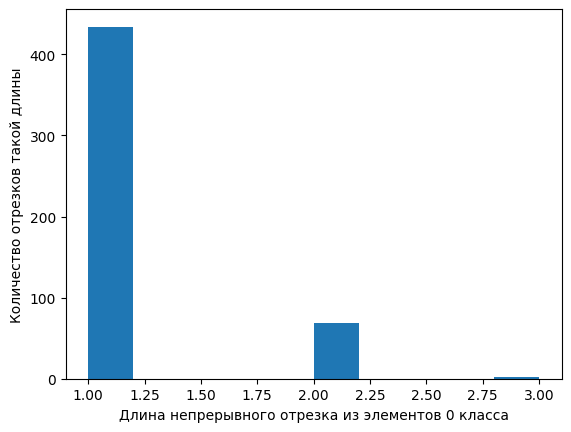

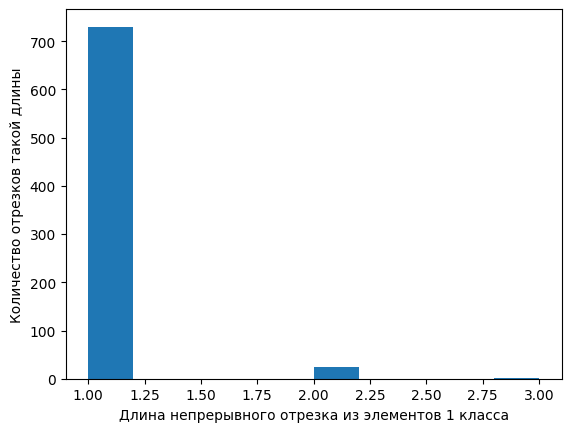

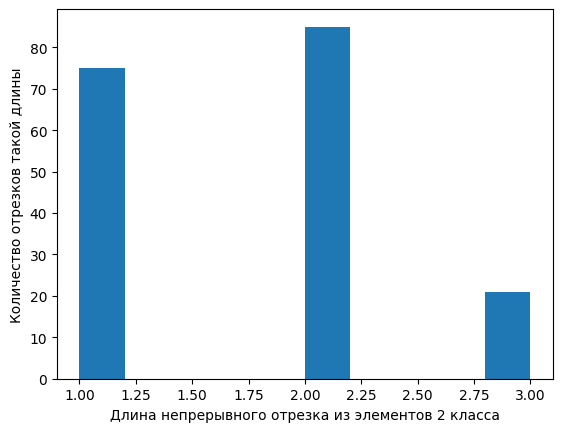

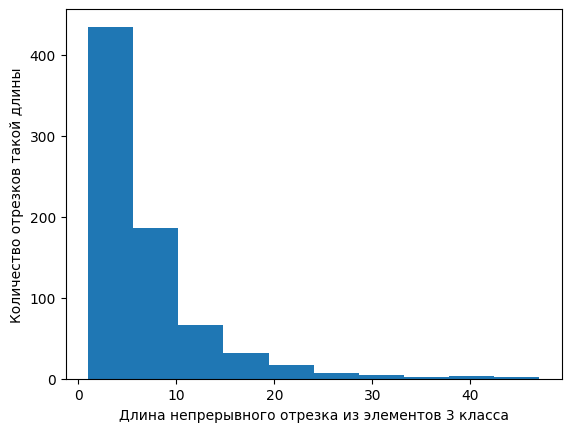

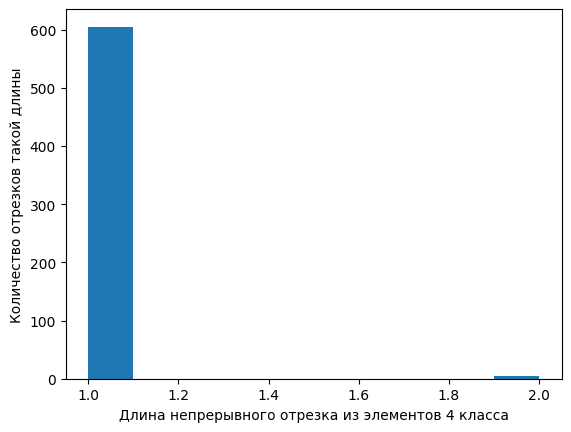

In [178]:
sections_for_clusters = calc_RLE(res)
for i in range(N_clusters):
    plt.hist(sections_for_clusters[i])
    plt.xlabel(f"Длина непрерывного отрезка из элементов {i} класса".format())
    plt.ylabel("Количество отрезков такой длины")
    plt.show()
# plt.legend()

In [30]:
columns = dataset.columns

In [113]:
train_X, train_y, test_X, test_y = split_to_train_and_test(dataset)


(43800, 7)
n_split=35040
train_X.shape=(35035, 7, 5), train_y.shape=(35035, 7), test_X.shape=(8745, 7, 5), test_y.shape=(8745, 7)


In [114]:
model, history = learn(train_X, train_y, test_X, test_y)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 7, 50)             11200     
                                                                 
 dense_9 (Dense)             (None, 7, 1)              51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
487/487 - 5s - loss: 161.0285 - val_loss: 156.8850 - 5s/epoch - 9ms/step
Epoch 2/10
487/487 - 3s - loss: 154.3784 - val_loss: 151.9624 - 3s/epoch - 5ms/step
Epoch 3/10
487/487 - 3s - loss: 150.1037 - val_loss: 148.0692 - 3s/epoch - 5ms/step
Epoch 4/10
487/487 - 3s - loss: 146.3915 - val_loss: 144.5203 - 3s/epoch - 5ms/step
Epoch 5/10
487/487 - 3s - loss: 142.8954 - val_loss: 141.1337 - 3s/epoch - 5ms/step
Epoch 6/10
487/487 - 2s -

In [118]:
predicted = model.predict(test_X)
print(predicted.shape)

274/274 [==============================] - 1s 2ms/step
(8745, 7, 1)


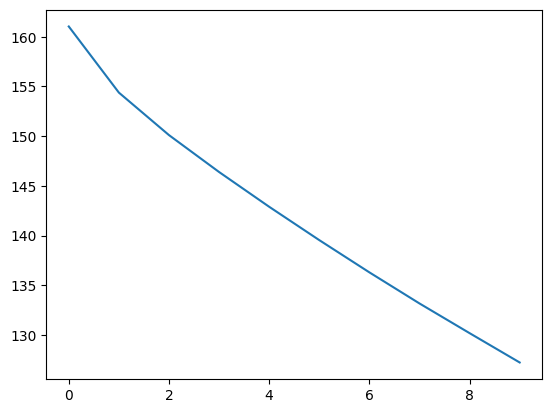

In [119]:
plt.plot(history.history['loss'], label='train')


In [127]:

predicted_values = predicted[100:200, ...]
print(f"{predicted_values.shape=}")

for i in range(predicted_values.shape[1]):
    plt.plot(predicted_values[:, i, 0], color="red", label="prediction")
    plt.plot(test_y[100:200, i], color="green", label="origin")
    plt.xlabel("Time")
    plt.ylabel(str(columns[i]))
    plt.legend()
    plt.savefig("plots/smallDataSet/" + str(i) + " " + str(columns[i]) + '.png')
    # plt.show()
    plt.clf()

predicted_values.shape=(100, 7, 1)


<Figure size 640x480 with 0 Axes>

In [16]:
data1 = pd.read_csv("MiningProcess_Flotation_Plant_Database.csv")

In [17]:
data1.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


In [18]:
data2 = preprocess(data1)

/tmp/ipykernel_426808/3816599972.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  df = df.groupby(df.index //5).mean() #усреднение
/home/anna/.local/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anna/.local/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/anna/.local/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
data2.head()

""
0
1
2
3
4


In [45]:
309600 64
241200 64
216001 84
226801 84
93601 88
201600 88
126000 88
237600 88
259200

SyntaxError: invalid syntax (3787536431.py, line 1)